# Исследование объявлений о продаже квартир

**Цель** - научиться определять рыночную стоимость объектов недвижимости.

**Задача** — установить параметры влияющие на цену. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность.

В нашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

**План**:
1. Открыть данные и изучить общую информацию;
2. Найти проблемы в данных (пропуски, дубликаты и пр.) и исправить их.
3. Вычислить и добавили в таблицу:
    - цену квадратного метра,
    - день недели, месяц и год публикации объявления,
    - этаж квартиры (первый, последний, другой),
    - соотношение жилой и общей площади,
    - отношение площади кухни к общей
4. Исследовать данные:
    - найти выбросы и аномалии если таковые имеются,
    - определить факторы, которые сильнее всего влияют на стоимость квартир в среднем,
    - определить центральную зону Санкт-Петербурга,
    - определить факторы, которые сильнее всего влияют на стоимость квартир в центральной зоне,
    - сравнить с влиянием этих факторов на стоимость квартир, вне центральной зоны
5. [Сделать общий вывод.](#total_conclusion)

### Шаг 1. Открытие файла с данными и изучение общей информации. 

In [54]:
import matplotlib.pyplot as plt
import pandas as pd
#!pip install pandas_profiling -U
import pandas_profiling
import datetime as dt

In [55]:
#таблица отображается неверно, столбцы разделены "\t"
# исправим ситуацию с помощью sep
try:
    df = pd.read_csv('/datasets/real_estate_data.csv', sep = '\t') #яндексовский путь.
except:
    df = pd.read_csv('real_estate_data.csv', sep = '\t') #мой путь
    
df.info()
display(df.sample(5))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
4202,8,9200000.0,98.9,2017-08-29T00:00:00,3,NaN,5.0,68.0,1,False,...,11.0,NaN,Санкт-Петербург,21542.0,5992.0,1.0,260.0,1.0,491.0,587.0
16850,4,6188957.0,90.2,2016-09-21T00:00:00,3,NaN,NaN,47.7,14,NaN,...,16.7,0.0,Санкт-Петербург,22041.0,17369.0,0.0,NaN,1.0,374.0,320.0
11501,5,4800000.0,60.1,2017-04-26T00:00:00,3,2.55,9.0,43.0,3,NaN,...,6.5,5.0,Санкт-Петербург,38177.0,10649.0,1.0,669.0,1.0,902.0,428.0
19036,2,3850000.0,40.3,2017-12-21T00:00:00,1,NaN,16.0,18.7,12,NaN,...,9.3,2.0,Санкт-Петербург,12859.0,15451.0,0.0,NaN,1.0,528.0,7.0
21439,10,7400000.0,79.8,2018-10-02T00:00:00,3,2.60,10.0,49.1,1,NaN,...,10.9,NaN,Санкт-Петербург,12534.0,12447.0,0.0,NaN,1.0,545.0,7.0


In [32]:
pandas_profiling.ProfileReport(df, minimal=True) #формирование отчета

Summarize dataset:   0%|          | 0/30 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

KeyboardInterrupt: 

#### Вывод

* в таблице использовались '\t' в качестве разделителя, из-за чего она неверно открывалась. проблема устранена. 
* в таблице 19,5% пропущенных значений, в том числе 38,8% пропусков в столбце ceiling_height и 88,3% в столбце is_apartment, 48,6% - balcony, 23,4% - airports_nearest, 23,3% - parks_around3000, 65,9% parks_nearest, 23,3% - ponds_around3000, 61,6% - ponds_nearest, 13,4% - days_exposition
* нет дубликатов
* в столбце ceiling_height странные высоты потолков (1 - 100).
* высоко коррелируют столбцы с общей и жилой площадями, что очевидно.
* можно заменить тип данных в is_apartment на bool, first_day_exposition на дату.

### Шаг 2. Предобработка данных
#### Обработка пропусков

In [4]:
#замена пропуском в числе балконов
df.loc[df['balcony'].isna(), 'balcony'] = 0
#df['balcony'].isna().sum()

заменим пропуски в количестве балконов на 0, т.к. если данных нет, то скорее всего балкона нет.

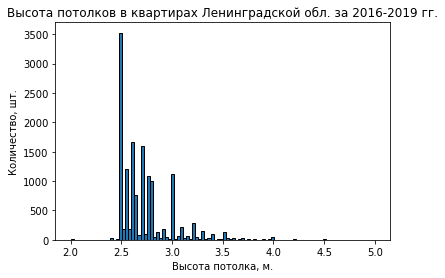

In [5]:
#распределение по высоте от 2 до 5 метров
df['ceiling_height'].plot(kind='hist', bins=100, range=(2, 5), ec='black',
                          title='Высота потолков в квартирах Ленинградской обл. за 2016-2019 гг.') 
plt.xlabel('Высота потолка, м.', color = 'black', fontsize='10', horizontalalignment='center')
plt.ylabel('Количество, шт.', color = 'black', fontsize='10', horizontalalignment='center')

df.loc[df['ceiling_height'].isna(), 'ceiling_height'] = df['ceiling_height'].median()
#df['ceiling_height'].isna().sum()

заменим на медианное значение, т.к. большинство домов имеют стандартную высоту потолка обычно 2,5 - 2,75 метра, что подтверждается гистограммой

In [6]:
#замена пустых значений количества этажей в доме.
df.loc[df['floors_total'].isna(), 'floors_total']= df['floor']
#df['floors_total'].isna().sum()

вероятно при продаже квартиры на последнем этаже этажность дома не дублировалась, поэтому заменим на этаж квартиры

In [7]:
# замена пропусков в is_apartment
df.groupby(['is_apartment', 'studio']).agg('count') #проверим относятся ли студии и open plan к квартирам
df.groupby(['is_apartment', 'open_plan']).agg('count')

df.loc[(df['is_apartment'].isna())&(df['studio'] ==True), 'is_apartment']=False   #заменяем пропуски для студий
df.loc[(df['is_apartment'].isna())&(df['open_plan'] ==True), 'is_apartment']=False   #заменяем пропуски для open plan

df.loc[df['is_apartment'].isna(), 'is_apartment'] = True  #замена оставшихся пропусков на True
#df['is_apartment'].isna().sum()

студии и open plan не относят к квартирам, значит можно заменить пропуски из этих категорий на False.
количество пропусков слишком огромное, возможно продавцы не отмечали
в нужной графе, что это квартира, т.к. писали это в заголовке объявления. 
поэтому заменим оставшиеся пропуски на True.

In [8]:
# заменим пропуски в жилой площади 
for i in df['rooms'].unique():   
    df.loc[df['living_area'].isna(), 'living_area'] =\
    df['total_area']*(df['living_area'].median()/df['total_area'].median())  
df['living_area'].isna().sum()

0

присутствует почти 8% пропусков значений жилой площади, поэтому удалять их нельзя. заменим по медианному соотношению жилой площади к общей, т.к. есть высокая корреляция (0,7) между общей и жилой площадями

In [9]:
#заполним пропуски в площади кухни
df.loc[df['kitchen_area'].isna(), 'kitchen_area'] = df['total_area'] - df['living_area']
#df['kitchen_area'].isna().sum()

пропуски в площади кухни заполним как разницу всей площади и жилой.

заполним пропуски до центра в зависимости от названия населенного пункта. в остальных колонках типа расстояние до пруда, аэропота и т.п. заполнять не будем, т.к. в дальнейшей работе их не используем.

In [10]:
#заполним пропуски в зависимости от названия населенного пункта
for type_unique in df['locality_name'].unique():
    df.loc[(df['cityCenters_nearest'].isna())&(df['locality_name'] ==type_unique), 'cityCenters_nearest']=\
    df.loc[df['locality_name'] ==type_unique, 'cityCenters_nearest'].median()

In [11]:
# посмотрим причины оставшихся пропусков
df.loc[df['airports_nearest'].isna()].pivot_table(index='locality_name', 
                                                  values=['airports_nearest', 'cityCenters_nearest', 'parks_around3000', 'parks_nearest', 'ponds_nearest'], 
                                                  aggfunc = 'sum').sort_values(by = 'airports_nearest')

,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_nearest
locality_name,,,,,
Бокситогорск,0.0,0.0,0.0,0.0,0.0
поселок Углово,0.0,0.0,0.0,0.0,0.0
поселок Тёсово-4,0.0,0.0,0.0,0.0,0.0
поселок Торковичи,0.0,0.0,0.0,0.0,0.0
поселок Терволово,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...
деревня Новое Девяткино,0.0,0.0,0.0,0.0,0.0
деревня Низино,0.0,0.0,0.0,0.0,0.0
деревня Нижняя,0.0,0.0,0.0,0.0,0.0


удалим троки с пропусками населенных пунктов, т.к. их только 49 и восстановить невозможно

In [12]:
df.dropna(subset=['locality_name'], inplace =True)
df['locality_name'].isna().sum()

0

в столбце с названиями населенных пунктов есть проблема - один тот же населенный пункт может быть указан с разными типами (село/деревня). удалим эти типы, оставив только названия.

In [13]:
def no_upper(string): 
    '''
    Функция берет на вход строку
    проверяем каждый символ строки на большую буква
    как только большая буква попадается ретурним остаток строки от большой буквы включительно 
    до последнего символа
    '''
    for i in range(len(string)):
        if string[i].isupper():
            return string[i: len(string)]

In [14]:
df['locality_name'] = df['locality_name'].apply(no_upper)
df['locality_name'].unique()

array(['Санкт-Петербург', 'Шушары', 'Янино-1', 'Парголово', 'Мурино',
       'Ломоносов', 'Сертолово', 'Петергоф', 'Пушкин', 'Кудрово',
       'Коммунар', 'Колпино', 'Красный Бор', 'Гатчина', 'Фёдоровское',
       'Выборг', 'Кронштадт', 'Кировск', 'Новое Девяткино',
       'Металлострой', 'Лебяжье', 'Сиверский', 'Молодцово',
       'Кузьмоловский', 'Новая Ропша', 'Павловск', 'Пикколово',
       'Всеволожск', 'Волхов', 'Кингисепп', 'Приозерск', 'Сестрорецк',
       'Куттузи', 'Аннино', 'Ефимовский', 'Плодовое', 'Заклинье',
       'Торковичи', 'Первомайское', 'Красное Село', 'Понтонный',
       'Сясьстрой', 'Старая', 'Лесколово', 'Новый Свет', 'Сланцы',
       'Путилово', 'Ивангород', 'Шлиссельбург', 'Никольское',
       'Зеленогорск', 'Сосновый Бор', 'Оржицы', 'Кальтино', 'Романовка',
       'Бугры', 'Рощино', 'Кириши', 'Луга', 'Волосово', 'Отрадное',
       'Павлово', 'Оредеж', 'Копорье', 'Молодёжное', 'Тихвин', 'Победа',
       'Нурма', 'Синявино', 'Тосно', 'Стрельна', 'Бокситогорск',

пропуски в сроке публикации скорее всего возникли из-за того, что объявление еще не снято. поэтому заполнять их не стоит.
есть ряд населенных пунктов типа: городской посёлок Янино-1, деревня Кудрово, Комунар и пр. по которым нет информации о расстоянии до аэропорта или количество водоемов, поэтому не предоставляется возможным заполнить пропуски в них, однако удалять тоже нельзя

In [15]:
#удалим пропуски в населенных пунктах
df.dropna(subset=['locality_name'], inplace=True)
#df['locality_name'].isna().sum()

#### замена типов данных

In [16]:
# замена float на int
df['floors_total'] = df['floors_total'].astype('uint8')
df['balcony'] = df['balcony'].astype('uint8')
df['last_price'] = df['last_price'].astype('uint32')

- количество этажей и баконов может быть только целыми числами. 
- у цен десятичная часть равна 0, поэтому ее можно безобидно удалить

In [17]:
# округление
df['living_area'] = round(df['living_area'])
df['kitchen_area'] = round(df['kitchen_area'])

столбцы с площадями получили большое количество знаков после запятой после заменя пропусков, их лучше сократить до 1 знака, как было изначально

In [18]:
# замена obj на bool
df['is_apartment'] = df['is_apartment'].astype('bool')

# перевод даты публикации из obj в формат даты с окурглением до дня
df['first_day_exposition'] = pd.to_datetime(df['first_day_exposition'], format='%Y-%m-%dT') 
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23650 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23650 non-null  int64         
 1   last_price            23650 non-null  uint32        
 2   total_area            23650 non-null  float64       
 3   first_day_exposition  23650 non-null  datetime64[ns]
 4   rooms                 23650 non-null  int64         
 5   ceiling_height        23650 non-null  float64       
 6   floors_total          23650 non-null  uint8         
 7   living_area           23650 non-null  float64       
 8   floor                 23650 non-null  int64         
 9   is_apartment          23650 non-null  bool          
 10  studio                23650 non-null  bool          
 11  open_plan             23650 non-null  bool          
 12  kitchen_area          23650 non-null  float64       
 13  balcony         

- тип столбца is_apartment можно заменить на bool т.к. в нем значения только True и False
- столбец с датами приведем к формату даты с округлением до дня, т.к. время не указано ни в одной строке.

#### Вывод

мы заменили пропуски в колонках количества балконов на 0, пропуски в значениях жилой площали заменили на основе медианного отношения жилой площади к общей. пропуски в кухонной площади заменили на разницу общей и жилой площади. пропуски в растояниях до ажропорта, центра и пр. пропуски в расстояниях до центра заменили на медианные значения в зависимости от названия населенного пункта. населенные пункты по котрым нет никакой информации (городской посёлок Янино-1, деревня Кудрово, Комунар и пр) оставим без изменений. пропуски в сроке публикации скорее всего появились потому что объевление еще не снято, заменять их не будем, т.к. неизвестно когда была сохранена эта база данных. удаллили пропускив населенных пунктах, т.к. их никак не восстановить.

переведем число балконов и этажей в int, т.к. они могут быть только целыми, цены перевели в int, т.к. десятичная часть равна 0, поэтому ее можно безобидно удалить. тип столбца is_apartment можно заменить на bool т.к. в нем значения только True и False. столбец с датами приведем к формату даты с округлением до дня, т.к. время не указано ни в одной строке. стоблцы с растояниями до аэропорта, центра, водоемов и пр. не могут быть приведены к int т.к. там остались пропуски.

### Шаг 3. Добавление в таблицу рассчетных значений.

In [19]:
#найдем цену за квадратный метр с округлением до десятых
df['price_per_meter'] = round((df['last_price']/df['total_area']), 1)

In [20]:
# создание столбцов с датами
#день недели публикации
df['weekday_exposition'] = df['first_day_exposition'].dt.weekday

#месяц
df['month_exposition'] = df['first_day_exposition'].dt.month

#год
df['year_exposition'] = df['first_day_exposition'].dt.year

In [61]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

In [62]:
# создадим категории этажей
def flat_floor(floor,floors_total):
    if floor == 1:
        return 'первый'
    if floor == floors_total:
        return 'последний'
    return 'другой'
df['floor_cathegory'] = df.apply(lambda x: flat_floor(x['floor'], x['floors_total']), axis=1)
df.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,flat_floor
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,...,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN,другой
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,...,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0,первый
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,...,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0,другой
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,...,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0,другой
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,...,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0,другой


In [22]:
#соотношение жилой и общей площадей
df['living_total'] = round(df['living_area']/df['total_area'], 3)

#соотношение кухни и общей площади
df['kitchen_total'] = round(df['kitchen_area']/df['total_area'], 3)
display(df.sample(5))

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,ponds_around3000,ponds_nearest,days_exposition,price_per_meter,weekday_exposition,month_exposition,year_exposition,floor_cathegory,living_total,kitchen_total
2025,6,5460000,68.0,2017-12-15,2,2.70,17,35.0,17,True,...,0.0,NaN,171.0,80294.1,4,12,2017,последний,0.515,0.250
12961,7,4600000,64.0,2018-12-31,2,2.75,9,39.0,7,True,...,NaN,NaN,NaN,71875.0,0,12,2018,другой,0.609,0.156
22944,6,2350000,31.0,2018-03-02,1,2.50,5,17.0,1,True,...,NaN,NaN,120.0,75806.5,4,3,2018,первый,0.548,0.161
5502,8,2950000,44.0,2019-02-04,2,2.65,5,28.0,4,True,...,NaN,NaN,NaN,67045.5,0,2,2019,другой,0.636,0.136
287,10,3100000,31.1,2016-06-09,1,2.50,5,18.0,4,True,...,2.0,315.0,520.0,99678.5,3,6,2016,другой,0.579,0.193


#### Вывод

мы посчитали и добавили в таблицу: 
- цену квадратного метра,
- день недели, месяц и год публикации объявления,
- этаж квартиры (первый, последний, другой),
- соотношение жилой и общей площади, 
- отношение площади кухни к общей.

### Шаг 4. Исследовательский анализ данных:
#### Поиск выбросов и аномалий

Сделаем функцию которая отобразит нужное количество корзин 

In [23]:
def my_bins(df,value):
    if df[value].max() > 100:
        return 100
    elif df[value].max() > 500:
        return  200
    elif df[value].max() > 1000:
        return  400
    else: return 20

создадим функцию которая чертит гистограммы и выводит общую информацию о столбце.

In [24]:
def my_hist(df, col, title_name, x_label, y_label):
    
    X = df.loc[(df[col] >= df[col].quantile(.02))&(df[col] <= df[col].quantile(.99)), col]
    X.plot(kind='hist', bins=my_bins(df, 'last_price'), ec='black')
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title_name)
    plt.grid()
    plt.show()
    print(df[col].describe())
    print('----------------------------------------------------------------')

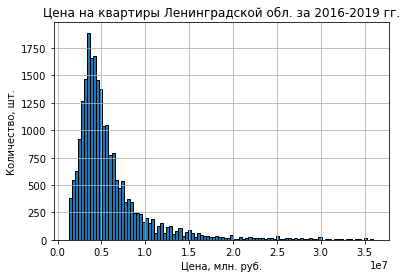

count    2.365000e+04
mean     6.541127e+06
std      1.089640e+07
min      1.219000e+04
25%      3.400000e+06
50%      4.650000e+06
75%      6.799000e+06
max      7.630000e+08
Name: last_price, dtype: float64
----------------------------------------------------------------


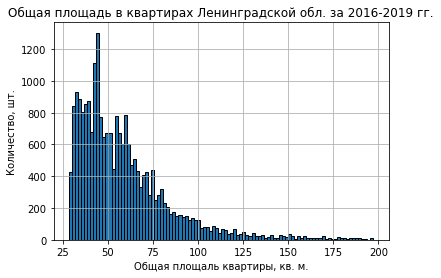

count    23650.000000
mean        60.329069
std         35.661808
min         12.000000
25%         40.000000
50%         52.000000
75%         69.700000
max        900.000000
Name: total_area, dtype: float64
----------------------------------------------------------------


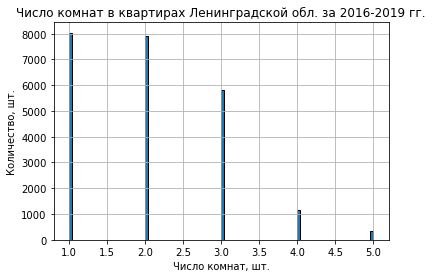

count    23650.000000
mean         2.070106
std          1.078620
min          0.000000
25%          1.000000
50%          2.000000
75%          3.000000
max         19.000000
Name: rooms, dtype: float64
----------------------------------------------------------------


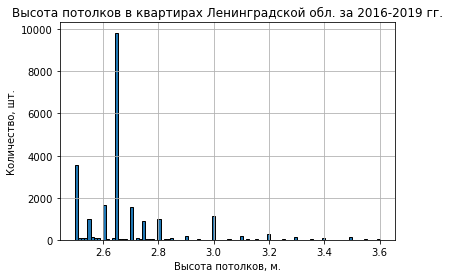

count    23650.000000
mean         2.724311
std          0.989255
min          1.000000
25%          2.600000
50%          2.650000
75%          2.700000
max        100.000000
Name: ceiling_height, dtype: float64
----------------------------------------------------------------


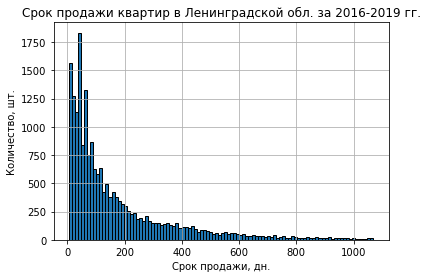

count    20470.000000
mean       180.753200
std        219.777916
min          1.000000
25%         45.000000
50%         95.000000
75%        231.000000
max       1580.000000
Name: days_exposition, dtype: float64
----------------------------------------------------------------


In [25]:
my_hist(df, 'last_price', 'Цена на квартиры Ленинградской обл. за 2016-2019 гг.', 'Цена, млн. руб.', 'Количество, шт.')
my_hist(df, 'total_area', 'Общая площадь в квартирах Ленинградской обл. за 2016-2019 гг.', 'Общая площаль квартиры, кв. м.', 'Количество, шт.')
my_hist(df, 'rooms', 'Число комнат в квартирах Ленинградской обл. за 2016-2019 гг.', 'Число комнат, шт.', 'Количество, шт.')
my_hist(df, 'ceiling_height', 'Высота потолков в квартирах Ленинградской обл. за 2016-2019 гг.', 'Высота потолков, м.', 'Количество, шт.')
my_hist(df, 'days_exposition', 'Срок продажи квартир в Ленинградской обл. за 2016-2019 гг.', 'Срок продажи, дн.', 'Количество, шт.')

- цены варируются от 400 тыс до 763 млн. однако цены выше 40 млн встречаются редко (141 шт).
- есть выбросы с ценой ~ 100 тыс и редкие случаи выше 100 млн (37 шт), удалим эти выбросы как аномалии
- наиболее часто встречающиеся цены 3,4-6,8 млн. 


- площади варируются от 12 до 900 кв. м. после 300 встречаются редко.
- удалим выбросы меньше 20 кв. м. и больше 300.
- похоже на распределение Пуассона


- число комнат варируется от 0 до 19. после 12 встречается только 4 шт. будем считать их аномалиями и удалим
- строки с 0 комнат относятся к студиям или open plan, поэтому заменим на 1.
- большая часть квартир находится в диапазоне 1-3 комнаты, что логично


- высота от 1 до 100 м. выше 6 м встречаются редко и до 2 м есть аномальные значения 1, 1.25, 1.75 м. будем считать их выбросами и удалим
- большая часть находится в промежутся от 2.6 до 2.7м

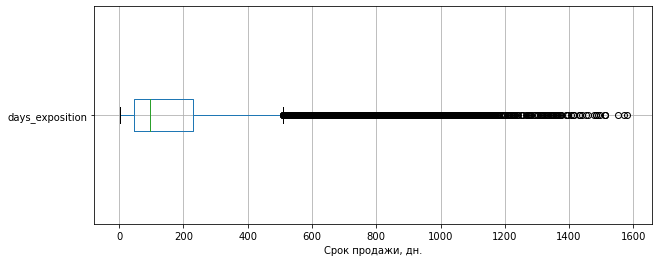

In [26]:
df.boxplot(column='days_exposition', figsize=(10, 4), vert=False)
plt.xlabel('Срок продажи, дн.', color = 'black', fontsize='10', horizontalalignment='center')
plt.show()

- срок продажи имеет очень большой диапазон от 1 дня до 1580 дней (4 года и 4 месяца)
- после 1200 дней встречается мало значений
- есть аномально выбивающиеся показатели 45 и 60 дней, закрытие объявлений в эти дни в 8 и 5 раз соответственно больше по сравнению с соседними значениями.
- также есть выброс равный 1 дню. 
- продажу можно считать быстрой если она была совершена раньше 44 дня, долгой если больше 220 дней и необычно долгой если дольше 1200 дней.
- медиана = 92 дням, среднее = 173 дня.

In [27]:
#удалим выбросы и редкие значения
#цены
df=df.loc[df['last_price']>200000]
df=df.loc[df['last_price']<100000000]

#площади
df=df.loc[df['total_area']>=20]
df=df.loc[df['total_area']<300]

# число комнат
df.loc[df['rooms']==0]=1 #0 комнат заменим на 1 
df=df.loc[df['rooms']<=8]

# высота потолков
df=df.loc[df['ceiling_height']>=2]
df=df.loc[df['ceiling_height']<6]

# удалим аномалии и выбросы в сроках продажи
df=df.loc[df['days_exposition']>1]
df=df.loc[df['days_exposition']<1400]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20148 entries, 1 to 23697
Data columns (total 29 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          20148 non-null  int64  
 1   last_price            20148 non-null  uint32 
 2   total_area            20148 non-null  float64
 3   first_day_exposition  20148 non-null  object 
 4   rooms                 20148 non-null  int64  
 5   ceiling_height        20148 non-null  float64
 6   floors_total          20148 non-null  uint8  
 7   living_area           20148 non-null  float64
 8   floor                 20148 non-null  int64  
 9   is_apartment          20148 non-null  object 
 10  studio                20148 non-null  object 
 11  open_plan             20148 non-null  object 
 12  kitchen_area          20148 non-null  float64
 13  balcony               20148 non-null  uint8  
 14  locality_name         20148 non-null  object 
 15  airports_nearest   

мы встретили:
- аномалии площади меньше 20 кв. м. и больше 300кв. м.;
- выброс с ценой ~ 0,1 млн и аномалии цены выше 100 млн;
- квартиры где 0 и более 8 комнат;
- аномальные высоты потолков ниже 2м и выше 6м;
- выброс равный 1 дню продажи и аномально долгие продажи более 1400 дней;
- аномально выбивающиеся показатели срока продажи квартир 45 и 60 дней, закрытие объявлений в эти дни в 8 и 5 раз соответственно больше по сравнению с соседними значениями.

#### Выявление факторов, больше всего влияющих на стоимость квартир.

In [28]:
#найдем зависимость стоимости от ряда факторов
df_factors=df[['last_price', 'total_area', 'rooms', 'floor_cathegory', 'cityCenters_nearest', 'weekday_exposition', 'month_exposition', 'year_exposition']]
df_factors.corr().style.background_gradient('coolwarm')

,last_price,total_area,rooms,cityCenters_nearest,weekday_exposition,month_exposition,year_exposition
last_price,1.000000,0.745312,0.454233,-0.303667,-0.000109,0.014720,-0.079922
total_area,0.745312,1.000000,0.784932,-0.244835,-0.005903,0.010312,-0.116773
rooms,0.454233,0.784932,1.000000,-0.182511,-0.003513,0.004530,-0.090829
cityCenters_nearest,-0.303667,-0.244835,-0.182511,1.000000,0.006256,-0.015674,0.039625
weekday_exposition,-0.000109,-0.005903,-0.003513,0.006256,1.000000,0.007899,0.007509
month_exposition,0.014720,0.010312,0.004530,-0.015674,0.007899,1.000000,-0.197971
year_exposition,-0.079922,-0.116773,-0.090829,0.039625,0.007509,-0.197971,1.000000


стоимость имеет:
- сильную прямую зависимость (0,74) с площадью, 
- слабую прямую зависимость (0,45) с числом комнат, 
- слабую обратную зависимость (-0,30) от расстояния от центра населенного пункта,
- очень слабую обратную зависимость от дня недели (-0,001) и года (-0,08) публикации объявления. т.е. в среднем квартиру публикуемые в начале недели незначительно дороже чем в конце недели, и в среднем в каджом следующем году квартиры незначительно дешеле.
- очень слабую прямую зависимость от месяца (0,01), т.е. в начале года квартиры незначительно дешевле чем в конце года

#### Определение центральной зоны города

In [29]:
# создадим таблицу с 10 населенными пунктами в которых больше всего объявлений
top_10=df.pivot_table(index = 'locality_name', values='price_per_meter', aggfunc=['count', 'mean'])
top_10.columns=['count', 'price_per_meter']
top_10 = top_10.sort_values(by='count', ascending = False).head(10)

# приведем цену за кв.м. в целые
top_10['price_per_meter']=top_10['price_per_meter'].astype('int')
top_10.sort_values(by='price_per_meter', ascending = False)  # 10 населенных пунктов с самыми дорогими квартирами

,count,price_per_meter
locality_name,,
Санкт-Петербург,13423,110947
Пушкин,302,101982
Кудрово,421,94227
Парголово,297,89537
Мурино,523,85099
Шушары,404,77710
Колпино,307,74763
Всеволожск,334,68549
Гатчина,267,67938


самая большая стоимость за кв.м в Санкт-Петербурге (110946 руб/кв.м), Пушкине (101982), деревне Кудрово (92297).
самая дешевая в Выборге (57084), Гатчине (67938), и Всеволжске (68549).

Text(0, 0.5, 'Цена, 10 млн.')

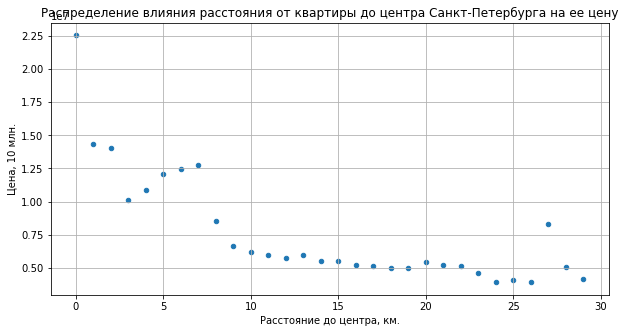

In [30]:
Saint_Petersburg=df.loc[df['locality_name']=='Санкт-Петербург'].reset_index(drop=True)
Saint_Petersburg['km_to_center'] = Saint_Petersburg['cityCenters_nearest'] = (Saint_Petersburg['cityCenters_nearest']/1000).round(0).astype('int')
SP_pivot=Saint_Petersburg.groupby(['cityCenters_nearest']).agg('mean').round(0)
SP_pivot.plot(kind ='scatter', x='km_to_center', y='last_price', figsize=(10, 5), grid=True, 
              title='Распределение влияния расстояния от квартиры до центра Санкт-Петербурга на ее цену')
plt.xlabel('Расстояние до центра, км.', color = 'black', fontsize='10', horizontalalignment='center')
plt.ylabel('Цена, 10 млн.', color = 'black', fontsize='10', horizontalalignment='center')

после 8 км начинается резкое снижение цены с 7 млн до 5,9 млн. отсюда следует что центальная зона - 8 км в радиусе.

#### Определение факторов влияющих на цену квартир в центральной зоне

In [31]:
# таблица с квартирами в центре Санкт-Петербурга
in_centre = Saint_Petersburg.loc[Saint_Petersburg['cityCenters_nearest']<=8].reset_index(drop=True)
display(in_centre.head())

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,ponds_nearest,days_exposition,price_per_meter,weekday_exposition,month_exposition,year_exposition,floor_cathegory,living_total,kitchen_total,km_to_center
0,0,64900000,159.0,2015-07-24 00:00:00,3,2.65,14,92.0,9,True,...,234.0,424.0,408176.1,4,7,2015,другой,0.579,0.421,7
1,2,10000000,100.0,2018-06-19 00:00:00,2,3.03,14,32.0,13,True,...,48.0,121.0,100000.0,1,6,2018,другой,0.320,0.410,8
2,8,6500000,97.2,2015-10-31 00:00:00,2,2.65,3,46.0,1,True,...,124.0,265.0,66872.4,5,10,2015,первый,0.473,0.206,2
3,6,15500000,149.0,2017-06-26 00:00:00,5,2.65,5,104.0,4,True,...,779.0,644.0,104026.8,0,6,2017,другой,0.698,0.114,4
4,7,45000000,161.0,2017-10-17 00:00:00,3,3.20,8,38.0,4,True,...,99.0,541.0,279503.1,1,10,2017,другой,0.236,0.311,7


In [32]:
def group_hist(df, col, title_name, x_label, y_label, nrow, ncol):
    '''
    функция строящая гистограммы для plt.subplots
    '''
    axes[nrow, ncol].hist(df[col], 
                          bins=my_bins(df, col), 
                          ec='black')
    axes[nrow, ncol].set_xlabel(x_label)
    axes[nrow, ncol].set_ylabel(y_label)
    axes[nrow, ncol].set_title(title_name)
    axes[nrow, ncol].grid()
    plt.subplots_adjust(wspace=0.3, hspace=0.3)

построим гистограммы по центру и всему Санкт-Петербургу.

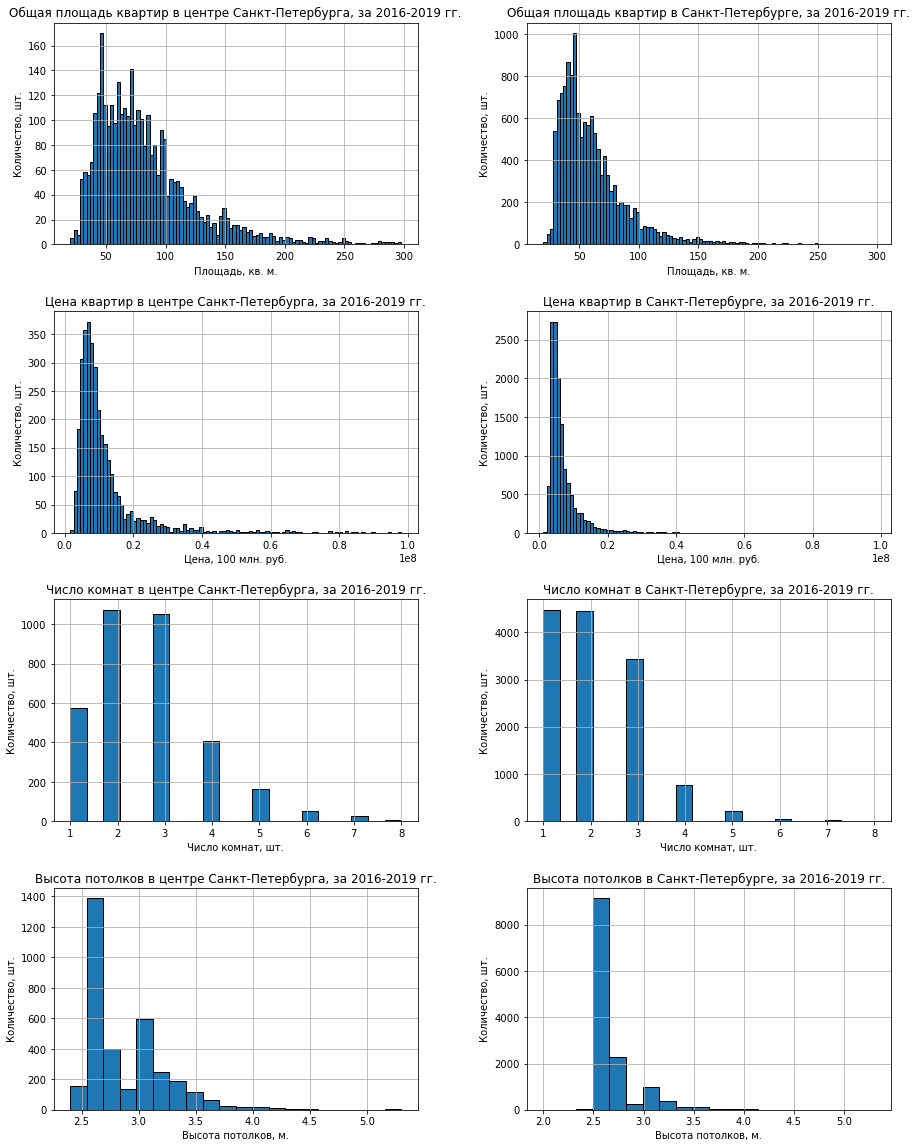

In [33]:
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(15, 20))

group_hist(in_centre, 'total_area', 'Общая площадь квартир в центре Санкт-Петербурга, за 2016-2019 гг.', 
           'Площадь, кв. м.', 'Количество, шт.', 0, 0)
group_hist(Saint_Petersburg, 'total_area', 'Общая площадь квартир в Санкт-Петербурге, за 2016-2019 гг.', 
           'Площадь, кв. м.', 'Количество, шт.', 0, 1)
group_hist(in_centre, 'last_price', 'Цена квартир в центре Санкт-Петербурга, за 2016-2019 гг.', 
           'Цена, 100 млн. руб.', 'Количество, шт.', 1, 0)
group_hist(Saint_Petersburg, 'last_price', 'Цена квартир в Санкт-Петербурге, за 2016-2019 гг.', 
           'Цена, 100 млн. руб.', 'Количество, шт.', 1, 1)
group_hist(in_centre, 'rooms', 'Число комнат в центре Санкт-Петербурга, за 2016-2019 гг.', 
           'Число комнат, шт.', 'Количество, шт.', 2, 0)
group_hist(Saint_Petersburg, 'rooms', 'Число комнат в Санкт-Петербурге, за 2016-2019 гг.', 
           'Число комнат, шт.', 'Количество, шт.', 2, 1)
group_hist(in_centre, 'ceiling_height', 'Высота потолков в центре Санкт-Петербурга, за 2016-2019 гг.', 
           'Высота потолков, м.', 'Количество, шт.', 3, 0)
group_hist(Saint_Petersburg, 'ceiling_height', 'Высота потолков в Санкт-Петербурге, за 2016-2019 гг.', 
           'Высота потолков, м.', 'Количество, шт.', 3, 1)

In [34]:
print(in_centre['ceiling_height'].describe())
print('--------------------')
print(Saint_Petersburg['ceiling_height'].describe())

count    3357.000000
mean        2.888275
std         0.334083
min         2.400000
25%         2.650000
50%         2.710000
75%         3.080000
max         5.300000
Name: ceiling_height, dtype: float64
--------------------
count    13423.000000
mean         2.711234
std          0.226740
min          2.000000
25%          2.600000
50%          2.650000
75%          2.700000
max          5.300000
Name: ceiling_height, dtype: float64


- квартиры в центре обычно больше и обладают большей вариативностью.
- цены в центре обычно выше, медианное значение для квартир в центре на 3,2 млн. выше чем для квартир по всему городу.
- в центре больше 2-х и 3-хкомнатных квартир, чем во всем Петербурге, там более распространены 1-комнатные квартиры.
- в центре потолки незначительно выше, не встречаются потолки ниже 2,4 м, в то время как во всем городе встречаются 2 м. медианная высота в центре 2,72 м., для всего города 2,65 м.

In [35]:
# таблица с изучаемыми факторами для центра
centre_factors=in_centre[['last_price', 'total_area', 'rooms', 'km_to_center', 'weekday_exposition', 'month_exposition', 'year_exposition']]
centre_factors.corr().style.background_gradient('coolwarm')

,last_price,total_area,rooms,km_to_center,weekday_exposition,month_exposition,year_exposition
last_price,1.000000,0.699922,0.415225,-0.095763,0.010985,0.019537,-0.103359
total_area,0.699922,1.000000,0.787320,-0.181602,-0.001841,0.014755,-0.135864
rooms,0.415225,0.787320,1.000000,-0.228997,-0.013175,0.007107,-0.098579
km_to_center,-0.095763,-0.181602,-0.228997,1.000000,0.025821,-0.013598,0.055034
weekday_exposition,0.010985,-0.001841,-0.013175,0.025821,1.000000,0.041895,0.018401
month_exposition,0.019537,0.014755,0.007107,-0.013598,0.041895,1.000000,-0.179482
year_exposition,-0.103359,-0.135864,-0.098579,0.055034,0.018401,-0.179482,1.000000


In [36]:
# таблица с изучаемыми факторами для всего Петербурга
SP_factors=Saint_Petersburg[['last_price', 'total_area', 'rooms', 'km_to_center', 'weekday_exposition', 'month_exposition', 'year_exposition']]
SP_factors.corr().style.background_gradient('coolwarm')

,last_price,total_area,rooms,km_to_center,weekday_exposition,month_exposition,year_exposition
last_price,1.000000,0.758269,0.471261,-0.368169,0.007143,0.012385,-0.087130
total_area,0.758269,1.000000,0.785197,-0.355705,-0.002534,0.008909,-0.128596
rooms,0.471261,0.785197,1.000000,-0.286802,-0.005711,0.006969,-0.099221
km_to_center,-0.368169,-0.355705,-0.286802,1.000000,-0.000488,0.003860,0.096500
weekday_exposition,0.007143,-0.002534,-0.005711,-0.000488,1.000000,-0.003381,0.012483
month_exposition,0.012385,0.008909,0.006969,0.003860,-0.003381,1.000000,-0.204630
year_exposition,-0.087130,-0.128596,-0.099221,0.096500,0.012483,-0.204630,1.000000


цены на квартиры в центре менее зависят от: 
- площади (0,70 против 0,76), 
- количества комнат (0,42 против 0,47), 
- расстояния до центра (-0,09 против -0,37)

но незначительно сильнее зависят от (хотя все еще практически не влияют на цену):
- от дня недели публикации (0,01 против 0,006)
- месяца публикации (0,018 против 0,012)
- года публикации (-0,1 против -0,09)

#### Вывод

мы нашли много аномалий и выбросов в данных, такие как: цена равная 200 тыс. и 763 млн., общая площадь 12 и 900 кв.м, более 15 комнат и потолки ниже 2 м и выше 50 м. аномальные значения были удалены, квартиры с 0 комнатами, относящиеся к студиям или open plan были заменены на 1.

срок продажи имеет диапазон от 1 дня до 1580 дней (4 года и 4 месяца). есть аномально выбивающиеся показатели 45 и 60 дней, закрытие объявлений в эти дни в 8 и 5 раз соответственно больше по сравнению с соседними значениями. продажу можно считать быстрой если она была совершена раньше 44 дня, долгой если больше 220 дней и необычно долгой если дольше 1200 дней.

самая большая стоимость за кв.м в Санкт-Петербурге (110946 руб/кв.м), Пушкине (101982), деревне Кудрово (92297). самая дешевая в Выборге (57084), Гатчине (67938), и Всеволжске (68549)

после 8 км начинается резкое снижение цены с 7 млн до 5,9 млн. отсюда следует что центальная зона - 8 км в радиусе.

квартиры в центре отличаются большими размерами и ценой по сравнению с квартирами во всем городе. а цены на квартиры незначительно менее зависимы от площади, количества комнат по сравнению со всем Петербургом и почти не зависимы от расстояния до центра. цена практически не зависит от даты публикации как во всем Петербурге, так и в центре.

### Шаг 5. Общий вывод <a id="total_conclusion"></a>

в таблице использовались '\t' в качестве разделителя, из-за чего она неверно открывалась.
в таблице было 19,5% пропущенных значений, мы заменили пропуски в колонках количества балконов на 0, пропуски в значениях жилой площали заменили на основе медианного отношения жилой площади к общей. пропуски в кухонной площади заменили на разницу общей и жилой площади. пропуски в растояниях до аэропорта, центра и пр.  пропуски в расстояниях до центра заменили на медианные значения в зависимости от названия населенного пункта. населенные пункты по котрым нет никакой информации (городской посёлок Янино-1, деревня Кудрово, Комунар и пр) оставим без изменений. пропуски в сроке публикации скорее всего появились потому что объевление еще не снято, заменять их не будем, т.к. неизвестно когда была сохранена эта база данных. удалили пропускив населенных пунктах, т.к. их никак не восстановить.

мы вычислили и добавили в таблицу: 
- цену квадратного метра,
- день недели, месяц и год публикации объявления,
- этаж квартиры (первый, последний, другой),
- соотношение жилой и общей площади, 
- отношение площади кухни к общей.

мы нашли много аномалий и выбросов в данных, такие как: цена равная 200 тыс. и 763 млн., общая площадь 12 и 900 кв.м, более 15 комнат и потолки ниже 2 м и выше 50 м. аномальные значения были удалены, квартиры с 0 комнатами, относящиеся к студиям или open plan были заменены на 1.

стоимость квартир имеет: сильную прямую зависимость (0,74) с площадью, слабую прямую зависимость (0,45) с числом комнат.

срок продажи имеет диапазон от 1 дня до 1580 дней (4 года и 4 месяца). есть аномально выбивающиеся показатели 45 и 60 дней, закрытие объявлений в эти дни в 8 и 5 раз соответственно больше по сравнению с соседними значениями. продажу можно считать быстрой если она была совершена раньше 44 дня, долгой если больше 220 дней и необычно долгой если дольше 1200 дней.

самая большая стоимость за кв.м в Санкт-Петербурге (110946 руб/кв.м), Пушкине (101982), деревне Кудрово (92297). самая дешевая в Выборге (57084), Гатчине (67938), и Всеволжске (68549)

после 8 км начинается резкое снижение цены с 7 млн до 5,9 млн. отсюда следует что центальная зона - 8 км в радиусе.

квартиры в центре отличаются большими размерами и ценой по сравнению с квартирами во всем городе. а цены на квартиры незначительно менее зависимы от площади (хотя зависимость сильная (0,7)), количества комнат по сравнению со всем Петербургом (средняя зависимость (0,42)) и почти не зависимы от расстояния до центра (-0,09). цена практически не зависит от даты публикации как во всем Петербурге, так и в центре.

**Рекомендации:**
- дать рекомендацию яндекс.недвижимости подтягивать высоту потолков автоматически по информации из росреестра.
- добавить колонку с расстоянием до метро (важный фактор влияющий на цену)